# Model Building on the FIFA World Cup

In the previous training document, we went through some examples of how Bayesian statistics may help us understand the outcome of a football game, looking at results only. In this tutorial, we take it one step further and build a Bayesian model using probability distributions, rather than discrete probability tables.  

We will be building three distinct prediction models using the average number of goals scored as the main input. We will also be testing these models on the actual dataset to check which one works the best:
1. Goal Scoring: predict match outcome prediction based on (historical) goal scoring ability
2. Simulate Goals: Predict scoreline and match outcome based on simulating outcomes from the poisson distribution
3. Skellam Distribution: Predict scoreline and match outcome based on the distribution function of the difference between two Poisson random variables.

There is no categorically right or wrong answer when it comes to model building.  In practice, each model will have its advantages and disadvantages.  When selecting your final model, you should consider the following aspects (amongst others):
* Bias-variance tradeoff
* Accuracy of model (on the training data?)
* Success of model (accuracy on out-of-sample data?)
* Run time (how long it takes to run?)
* Parameterisation (how many model parameters does it need to have maintained?)
* Interpretability of results (how easy is it to make sure the model is behaving as expected?)

## [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution) - A Primer from Wikipedia

In probability theory and statistics, the Poisson distribution, named after French mathematician Siméon Denis Poisson, is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant rate and independently of the time since the last event.

An event can occur 0, 1, 2, … times in an interval. The average number of events in an interval is designated $\lambda$  (lambda). Lambda is the event rate, also called the rate parameter. The probability of observing k events in an interval is given by the equation:

$$P(k) = e^{-\lambda}\frac{\lambda^k}{k!}$$

where:
* $\lambda$ is the average number of events per interval
* $e$ is the number 2.71828... (Euler's number) the base of the natural logarithms
* $k$ takes values 0, 1, 2, …
* $k!$ = $k$ × ($k$ − 1) × ($k$ − 2) × … × 2 × 1 is the factorial of $k$

In [1]:
# imports
from sqlalchemy import create_engine
import psycopg2

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import factorial
%matplotlib inline

In [2]:
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

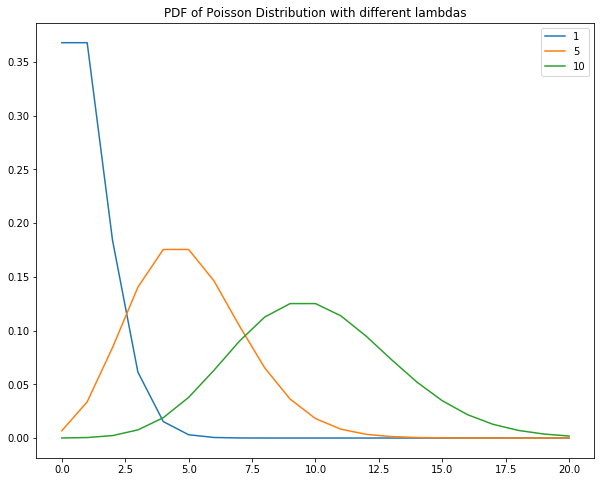

In [3]:
lambdas = [1, 5, 10]
plot_poisson = [[poisson(k, lamb) for k in range(21)] for lamb in lambdas]
plot_poisson = pd.DataFrame(plot_poisson).T
plot_poisson.columns = lambdas
plot_poisson.plot(title='PDF of Poisson Distribution with different lambdas', figsize=(10, 8))

### The Poisson distribution is an appropriate model if the following assumptions are true:

1. k is the number of times an event occurs in an interval and k can take discrete integer values 0, 1, 2, ….(no negatives)
2. The occurrence of one event does not affect the probability that a second event will occur. That is, events occur independently.
3. The rate at which events occur is constant. The rate cannot be higher in some intervals and lower in other intervals.
4. Two events cannot occur at exactly the same instant; instead, at each very small sub-interval exactly one event either occurs or does not occur.
5. The probability of an event in a small sub-interval is proportional to the length of the sub-interval.

Sense check: do these rules apply to the number of goals scored by a team in a football match?

# Getting the data and generating a naive / benchmark model

We will need to select the matches and the team names, here is how to get the data from an Amazon RDS instance!

In [4]:
#connect to the sql dataset on AWS 
db_settings = {'host' : 'edsasoccerinstance.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com', 'dbname' : 'edsaLeagueSoccerDatabase', 'user' : 'edsaSoccer', 'password' : 'edsaSoccer'} 
conn_string = ' '.join(["{}='{}'".format(k, v) for k, v in db_settings.items()]) 
print (conn_string)
conn_rds = psycopg2.connect(conn_string) 
print('Created connection')

teams = pd.read_sql_query("select * from team", con=conn_rds) 
teams.set_index('team_api_id', inplace=True)
matches = pd.read_sql_query("select * from match", con=conn_rds) 

print('Size of match data retrieved: {}'.format(matches.shape))
print('Size of team data retrieved: {}'.format(teams.shape))

host='edsasoccerinstance.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com' dbname='edsaLeagueSoccerDatabase' user='edsaSoccer' password='edsaSoccer'
Created connection
Size of match data retrieved: (25979, 115)
Size of team data retrieved: (299, 4)


So we have almost 26,000 matches involving 299 teams to analyse.

In [5]:
# join the 2 datasets to work with the more familiar team names
df = matches.join(teams['team_long_name'], on='home_team_api_id', rsuffix='_home')

In [6]:
df = df.join(teams['team_long_name'], on='away_team_api_id', rsuffix='_away')
df.rename(columns={'team_long_name': 'home_team', 'team_long_name_away' : 'away_team'}, inplace=True)

In [7]:
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team,away_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,KAA Gent,RAEC Mons
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,FCV Dender EH,Standard de Liège


In [8]:
df['total_goals'] = df['home_team_goal'] + df['away_team_goal']

In [9]:
df['home_win'] = (df['home_team_goal'] > df['away_team_goal']).astype('int')
df['away_win'] = (df['home_team_goal'] < df['away_team_goal']).astype('int')
df['outcome']  = df['home_win'] - df['away_win']
rename_outcome = {-1: 'away_win', 0:'draw', 1:'home_win'}
df['outcome_name'] = df['outcome'].apply(lambda x: rename_outcome[x])

In [10]:
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,BSH,BSD,BSA,home_team,away_team,total_goals,home_win,away_win,outcome,outcome_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.73,3.40,4.20,KRC Genk,Beerschot AC,2,0,0,0,draw
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren,0,0,0,0,draw
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht,3,0,1,-1,away_win
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,1.44,3.75,6.50,KAA Gent,RAEC Mons,5,1,0,1,home_win
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,4.75,3.30,1.67,FCV Dender EH,Standard de Liège,4,0,1,-1,away_win


In [11]:
df[['home_win', 'away_win']].mean()

home_win    0.458717
away_win    0.287386
dtype: float64

## Naive Benchmark  (Model 0)

The home team wins on average 46% of the time with the away team wining 29% of the time.  Lets use this as a benchmark for a model which randomly selects an outcome according to this probability.

In [12]:
home, away = df[['home_win', 'away_win']].mean()
def model_0_naive(home, away):
    return np.random.choice(['home_win', 'draw', 'away_win'], size=1, p =[home, 1 - home - away, away])[0]

In [13]:
model_0_naive(0.458717,0.287386)

'draw'

# Does a Poisson Distribution fit the number of goals scored in a game?

Let's first do a sense check of whether the number of goals scored in a game can indeed be modelled by a Poisson distribution?

In [14]:
ave_home_goals = (df['home_team_goal']).mean()
ave_away_goals = (df['away_team_goal']).mean()
total_goals = (df['total_goals']).mean()
print ("Home teams score on average {:0.2f} goals compared to {:0.2f} goals per away team".format(ave_home_goals, ave_away_goals))

Home teams score on average 1.54 goals compared to 1.16 goals per away team


In [15]:
# generate a PMF for the Poisson based on this data
# Let's see the PMF for all the way to 30 customers, remeber theoretically an infinite number of customers could show up.
k = range(0, 11)

#The PMF we'll use to plot
pmf_pois = [[poisson(i,lamb) for i in k] for lamb in [total_goals, ave_home_goals, ave_away_goals]]

In [16]:
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,BSH,BSD,BSA,home_team,away_team,total_goals,home_win,away_win,outcome,outcome_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.73,3.40,4.20,KRC Genk,Beerschot AC,2,0,0,0,draw
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.91,3.25,3.60,SV Zulte-Waregem,Sporting Lokeren,0,0,0,0,draw
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.30,3.20,2.75,KSV Cercle Brugge,RSC Anderlecht,3,0,1,-1,away_win
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,1.44,3.75,6.50,KAA Gent,RAEC Mons,5,1,0,1,home_win
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,4.75,3.30,1.67,FCV Dender EH,Standard de Liège,4,0,1,-1,away_win


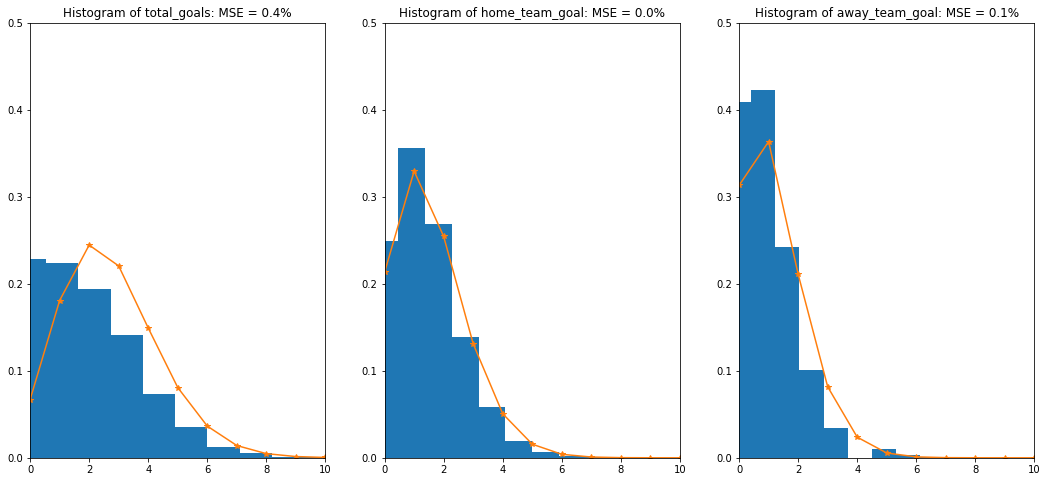

In [17]:
from sklearn.metrics import mean_squared_error
fig, ax = plt.subplots(1, 3, figsize=(18, 8))
for i, goals in enumerate(['total_goals', 'home_team_goal', 'away_team_goal']):
    a, _, _ = ax[i].hist(df[goals], bins= len(k), density = True, align='left')
    ax[i].plot(pmf_pois[i], '-*')
    mse = mean_squared_error(a, pmf_pois[i])*100
    ax[i].set_title('Histogram of {:s}: MSE = {:0.1f}%'.format(goals, mse))
    ax[i].set_xlim([0, 10])
    ax[i].set_ylim([0, 0.5])    

In [18]:
# check for overdispersion
print(df[['home_team_goal','away_team_goal','total_goals']].mean(axis=0))
print(df[['home_team_goal','away_team_goal','total_goals']].var(axis=0))

home_team_goal    1.544594
away_team_goal    1.160938
total_goals       2.705531
dtype: float64
home_team_goal    1.682619
away_team_goal    1.304416
total_goals       2.797110
dtype: float64


That's a good start on the Poisson distribution assumptions. Number of goals scored is strictly greater than or equal to zero.  There is also a set amount of time to score goals in a game (assuming no extra time) and there can definitely not be more than one goal scored at the same time in a game

* So we can see that the poisson distribution accurately reflects the goals scored by the home team
* for away goals, the average away goals apears to be slighty overstated, than the underlying distribution with the actual number of goals <=1 being **slightly** more likely than the PMF would predict.
* the poisson has an interesting characteristic, in that the sum of 2 poisson distribution is itself poisson with $\lambda_{sum} = \lambda_1 +\lambda_1$ 

# Goal Scoring (Model 1)
## Predict a match outcome prediction based on (historical) goal scoring ability

In this section we will be building a model that will predict matches based on how good teams are at scoring goals.  The logic of the model is that if a team scores a lot of goals, on average, and plays against a team that does not score a lot of goals, they are more likely to win the game.  We will be building the model based on the average number of goals scored by a team in a game. 

The input to this model will be the average number of goals scored for the home team and away teams. The output will be a prediction for a `home team win`, `draw`, and `away team win`.

This model will be based directly on probablities derived from the data.

In [19]:
# calculate the number of goals scored on average by the home team, and way team
home_team_goals = df[['home_team', 'home_team_goal']].groupby('home_team').mean()
away_team_goals = df[['away_team', 'away_team_goal']].groupby('away_team').mean()

all_goals = home_team_goals.join(away_team_goals, lsuffix='_home', rsuffix='_away')

In [21]:
rename_goals = {
     'home_team_goal' : 'Home Average Goals', 
     'away_team_goal' : 'Away Average Goals'}
all_goals.rename(columns=rename_goals, inplace=True)

In the next step we will be dividing the goals in quintiles, so grouping the number of goals on average into 5 buckets with an equale number of observations in them. 

In [22]:
labels=['Very Low', 'Low', 'Ave', 'High', 'Very High']

In [23]:
all_goals['Home_bucket'] = pd.qcut(all_goals['Home Average Goals'], 5)
all_goals['Away_bucket'] = pd.qcut(all_goals['Away Average Goals'], 5)

In [24]:
home_bucket = {a : b for a, b in zip(all_goals['Home_bucket'].cat.categories, labels)}
away_bucket = {a : b for a, b in zip(all_goals['Away_bucket'].cat.categories, labels)}

In [25]:
all_goals['Goal scoring ability of home team'] = all_goals.apply(lambda x: home_bucket[x['Home_bucket']], axis=1)
all_goals['Goal scoring ability of away team'] = all_goals.apply(lambda x: away_bucket[x['Away_bucket']], axis=1)

In [26]:
all_goals.head()

,Home Average Goals,Away Average Goals,Home_bucket,Away_bucket,Goal scoring ability of home team,Goal scoring ability of away team
home_team,,,,,,
1. FC Kaiserslautern,1.088235,1.029412,"(0.587, 1.088]","(0.947, 1.067]",Very Low,Ave
1. FC Köln,1.137255,1.078431,"(1.088, 1.263]","(1.067, 1.263]",Low,High
1. FC Nürnberg,1.270588,1.000000,"(1.263, 1.406]","(0.947, 1.067]",Ave,Ave
1. FSV Mainz 05,1.436975,1.252101,"(1.406, 1.66]","(1.067, 1.263]",High,High
AC Ajaccio,1.122807,0.912281,"(1.088, 1.263]","(0.831, 0.947]",Low,Low


In [27]:
df = df.join(all_goals[['Home_bucket', 'Home Average Goals', 'Goal scoring ability of home team']], on='home_team')
df = df.join(all_goals[['Away_bucket', 'Away Average Goals', 'Goal scoring ability of away team']], on='away_team')

In [28]:
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_win,away_win,outcome,outcome_name,Home_bucket,Home Average Goals,Goal scoring ability of home team,Away_bucket,Away Average Goals,Goal scoring ability of away team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,0,0,0,draw,"(1.66, 3.322]",1.933962,Very High,"(0.262, 0.831]",0.815789,Very Low
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,0,0,0,draw,"(1.406, 1.66]",1.660377,High,"(1.067, 1.263]",1.226415,High
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,0,1,-1,away_win,"(1.263, 1.406]",1.307692,Ave,"(1.263, 2.329]",1.698113,Very High
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,1,0,1,home_win,"(1.66, 3.322]",1.954128,Very High,"(1.067, 1.263]",1.127660,High
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,0,1,-1,away_win,"(1.088, 1.263]",1.235294,Low,"(1.263, 2.329]",1.339623,Very High


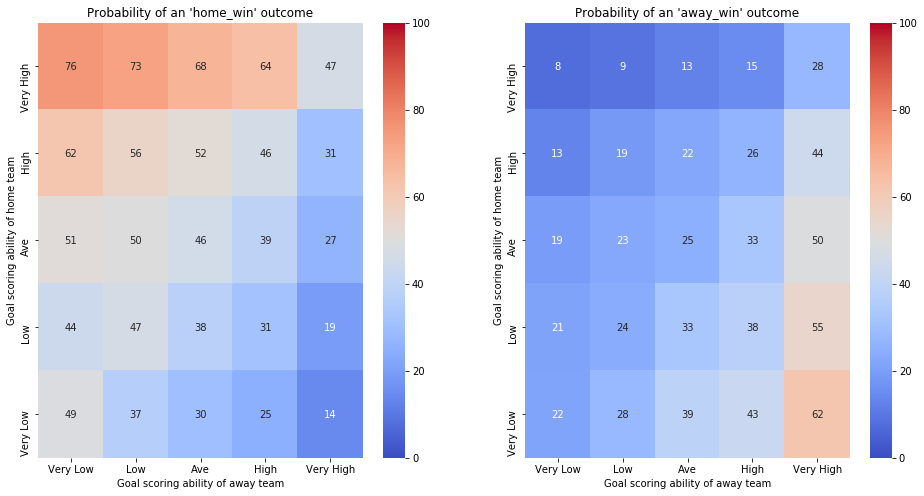

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
predict_winner = {}
for i, j in enumerate(['home_win', 'away_win']):
    predict_winner[j] = df.pivot_table(values=j, 
                                       index='Goal scoring ability of home team', 
                                       columns='Goal scoring ability of away team', aggfunc='mean')
    # sort the labels correctly    
    predict_winner[j] = predict_winner[j][labels]
    predict_winner[j] = predict_winner[j].loc[labels[::-1]]
    
    sns.heatmap(predict_winner[j]*100, annot=True, fmt='0.0f', ax=ax[i], cmap='coolwarm', vmin=0, vmax=100)
    ax[i].set_title("Probability of an '{:s}' outcome".format(j))

There seems to be a good model here.  How do we turn it into a prediction?

In [30]:
def model_1_goals_scored(team1, team2, home_bucket, away_bucket, predict_winner):
    def return_bucket(x, bucket):
        min_val, min_buck = 100, ''
        max_val, max_buck = 0, ''
        for interval, label in bucket.items():
            if x in interval:
                return label
            
            # catch errors outside of buckets
            if interval.left < min_val:                
                min_val, min_buck = interval.left, label
            if interval.right > max_val:                
                max_val, max_buck = interval.right, label
            
        if x <= min_val: return min_buck
        if x >= max_val: return max_buck
    
    team1_buck = return_bucket(team1, home_bucket)
    team2_buck = return_bucket(team2, away_bucket)
    
    home_win = predict_winner['home_win'][team2_buck].loc[team1_buck]
    away_win = predict_winner['away_win'][team2_buck].loc[team1_buck]
    
    return home_win, 1 - home_win - away_win, away_win
        

In [31]:
model_1_goals_scored(2, 1, home_bucket, away_bucket, predict_winner)

(0.6773794808405439, 0.19406674907292953, 0.12855377008652658)

So this model predicts that the when a team with a goal average of 2 plays a team with a goal average of 1, they will win 68% of the time!

## Simulate Goals (Model 2)
### Predict scoreline and match outcome based on simulating outcomes from the poisson distribution

But method 1 doesn't give us a distribution of the scoreline.  We will use the poisson distribuion here:
* simulate the number of goals scored by the home team
* simulate the number of goals scored by the away team
This should give us an estimate of the number of goals scored and then the result.

In [32]:
from scipy.stats import poisson

In [33]:
def model_2_simulate_goals(team1, team2, simulations=10000):    
    """reads in the average number of goals scored by team football teams
    
    Goals scores are simulated using a poisson distribution for each time 
    
    the output is a prediction of the team1 win, draw and team2 win
    the second output is a prediction of each different scoreline"""
    
    # randomly generate goals for each team
    predict_score = pd.DataFrame(np.zeros((simulations, 2)), columns=['Team1 Goals Scored', 'Team2 Goals Scored'])    
    predict_score['Team1 Goals Scored'] = np.random.poisson(lam=team1, size=simulations)
    predict_score['Team2 Goals Scored'] = np.random.poisson(lam=team2, size=simulations)
    
    # predict outcome 
    predict_score['Team1_win'] = (predict_score['Team1 Goals Scored'] > predict_score['Team2 Goals Scored']).astype('int')
    predict_score['Team2_win'] = (predict_score['Team1 Goals Scored'] < predict_score['Team2 Goals Scored']).astype('int')
    predict_score['Draw'] = (predict_score['Team1 Goals Scored'] == predict_score['Team2 Goals Scored']).astype('int')    
    
    # generate the scoreline probability distribution
    predict_result = pd.crosstab(predict_score['Team1 Goals Scored'], predict_score['Team2 Goals Scored']) / simulations    
    home_win, draw, away_win =  predict_score[['Team1_win', 'Draw','Team2_win']].mean()
    
    return (home_win, 1 - home_win - away_win, away_win), predict_result
    

In [34]:
outcome, score = model_2_simulate_goals(2, 1)

In [35]:
outcome

(0.6093, 0.21150000000000005, 0.1792)

In this case, the model predict that team 1 (with goal average of 2) will win ~61% of the time when playing a team with goal scoring average of 1. This may differ slightly everytime you run it based on the random seed of for the generation of goals.

Text(0.5,1,'Probability of each scoreline')

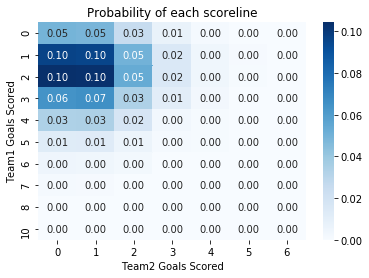

In [36]:
ax = plt.axes()
sns.heatmap(score, cmap='Blues', annot=True, fmt='0.2f', ax=ax)
ax.set_title('Probability of each scoreline')

This chart can be interpreted that there is a 10% chance of a game ending up as 1-0 to the home team.  All the probabilities lying along the diagonal sum to the probability of a draw. All probabilities that lie below the diagonal (bottom left half) are predictions for a home/team2 win.

## Skellam Distribution (Model 3)

### Predict scoreline and match outcome based on the distrution function of the difference in 2 Poisson random variables


The [Skellam distribution](https://en.wikipedia.org/wiki/Skellam_distribution) is the discrete probability distribution of the difference of two statistically independent random **Poisson** variables. It is useful in describing the point spread distribution in sports where all scored points are equal, such as baseball, hockey and soccer.

We will be using the built-in skellam distribution from the from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skellam.html) library

In [37]:
from scipy.stats import skellam

In [38]:
def model_3_skellem(team1, team2, max_goals=10):
    goals = range(-max_goals, max_goals + 1)
    predict_margin = skellam.pmf(goals, team1, team2)    
    
    home = sum(predict_margin * [1 if i > 0 else 0 for i in goals])
    draw = sum(predict_margin * [1 if i == 0 else 0 for i in goals])
    away = sum(predict_margin * [1 if i < 0 else 0 for i in goals])    
    
    return (home, draw, away)

In [39]:
model_3_skellem(2, 1)

(0.6056995426718595, 0.21171208396194352, 0.1825847733274208)

In this case, the model predict that team1 (with goal average of 2) will win ~61% of the time when playing a team with goal scoring average of 1.  As the number of simulations increases in model 2, so it should approximate to the skellem distribution output.

# Naive Bayes Classifier (Model 4)

[Naive Bayes models](https://github.com/jakevdp/PythonDataScienceHandbook/blob/599aa0fe3f882c0001670e676e5a8d43b92c35fc/notebooks/05.05-Naive-Bayes.ipynb) are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem.

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
naive_bayes = GaussianNB()

In [42]:
naive_bayes.fit(df[['Home Average Goals', 'Away Average Goals']], df['outcome_name']);

In [43]:
list(naive_bayes.classes_)

['away_win', 'draw', 'home_win']

In [44]:
naive_bayes.predict_proba(np.array([2, 1]).reshape(1, -1))

array([[0.09599495, 0.19349947, 0.71050558]])

In [45]:
naive_bayes.predict(np.array([2, 1]).reshape(1, -1))

array(['home_win'], dtype='<U8')

In [46]:
def model_4_naive_bayes(team1, team2, NB, element=None):
    prediction = NB.predict_proba(np.array([2, 1]).reshape(1, -1))
    prediction = pd.DataFrame(prediction, columns=NB.classes_)    
    
    if element >= 0:
        return prediction[['home_win', 'draw', 'away_win']].loc[element].values
    else:
        return prediction[['home_win', 'draw', 'away_win']]

In [47]:
model_4_naive_bayes(2, 1, naive_bayes, 0)

array([0.71050558, 0.19349947, 0.09599495])

In this case the Naive Bayes model predicts that a team with an average of 2 goals per game will win 71% of the time when they play against a team with an average of 1 goal per game!

# So, which model is best?

How do we evaluate which model is best?  Let's start off by comparing the three models given 2 teams that play against each other.  You can change the `team1` and `team2` variables to see what the different outcomes look like...

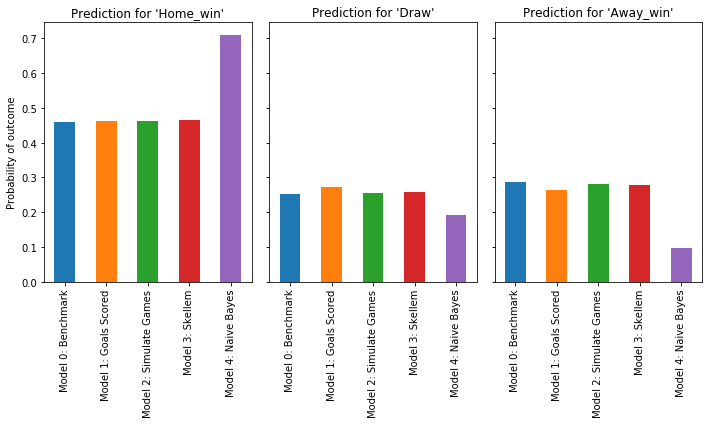

In [48]:
# set average goals per team
team1 = 1.5
team2 = 1.1

# generate predictions
m0 = (home, 1 - home - away, away)
m1 = model_1_goals_scored(team1, team2, home_bucket, away_bucket, predict_winner)
m2 = model_2_simulate_goals(team1, team2)[0]
m3 = model_3_skellem(team1, team2)
m4 = model_4_naive_bayes(team1, team2, naive_bayes, 0)

# plot results
models = ['Model 0: Benchmark', 'Model 1: Goals Scored', 'Model 2: Simulate Games', 'Model 3: Skellem', 'Model 4: Naive Bayes']
compare_results = pd.DataFrame([m0, m1, m2, m3, m4], columns=['Home_win', 'Draw', 'Away_win'], index=models)

fig, ax = plt.subplots(1,3, figsize=(10, 6), sharey=True)
for i, c in enumerate(compare_results.columns):
    compare_results[c].plot(kind='bar', ax=ax[i])
    ax[i].set_title("Prediction for '{:s}'".format(c))
    ax[i].set_ylabel('Probability of outcome')

plt.tight_layout()

So if you are only given the number of goals a team has scored on average, which model is the best at predicting the outcome of the game?  Let's test it on a random sample of 100 games.

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [50]:
cols = ['id', 'home_team', 'away_team', 'outcome_name', 'home_team_goal', 'away_team_goal', 'Home Average Goals', 'Away Average Goals']

In [51]:
predict_df = df[cols]
predict_df = predict_df.sample(n=100)

In [52]:
def prediction(three_outcomes, spread=0.15):
    ## here we use the same `certainty` metric as in the last tutorial, 
    ## where we predict a winner only if there is a difference in probabiityes of more than 'spread' percent 
    ## (set to 15% as a default)
    home_win, draw, away_win = zip(*three_outcomes) 
    home_win = np.array(home_win)
    away_win = np.array(away_win)
    certainty = home_win - away_win
    
    outcomes = ['draw'] * len(certainty)    
    outcomes = ['home_win' if c > spread else o for o, c in zip(outcomes, certainty)]
    outcomes = ['away_win' if c < -spread else o for o, c in zip(outcomes, certainty)]
    
    return pd.Series(outcomes, index=three_outcomes.index)

### Model 0: Naive Benchmark

In [53]:
predict_df['model_0'] = predict_df.apply(lambda x: model_0_naive(home, away), axis=1)

In [54]:
accuracy_score(predict_df['outcome_name'], predict_df['model_0'])

0.36

In [55]:
confusion_matrix(predict_df['outcome_name'], predict_df['model_0'])

array([[ 8,  8,  9],
       [ 7,  6, 13],
       [14, 13, 22]], dtype=int64)

### Model 1: Goals Scored

In [56]:
model_1 = predict_df.apply(lambda x: model_1_goals_scored(x['Home Average Goals'], \
                                                                  x['Away Average Goals'], \
                                                                  home_bucket, \
                                                                  away_bucket, \
                                                                  predict_winner), axis=1)

In [57]:
predict_df['model_1'] = prediction(model_1)

In [58]:
accuracy_score(predict_df['outcome_name'], predict_df['model_1'])

0.51

In [59]:
confusion_matrix(predict_df['outcome_name'], predict_df['model_1'])

array([[ 6,  8, 11],
       [ 3,  8, 15],
       [ 4,  8, 37]], dtype=int64)

### Analysis of model 1
1. (+ve) Good interpretability - makes sense that better teams usually have better goal scoring ability
2. (+ve) Run time is pretty effective, each prediction needs to make 2 lookups into a table
3. (+ve) Should have good bias as it uses all the historical data, but may not be effective if future distributions change
3. (-ve) There are alot of paramters to maintain:
    * it requires the 2 quintiles dataset for goals scored, in addtion to
    * 2 x 5 x 5 matrixes of probabilities that characterise the model
4. (-ve) Only gives a game prediction, with no probability for score line

### Model 2: Simulate Games

In [60]:
model_2 = predict_df.apply(lambda x: model_2_simulate_goals(x['Home Average Goals'], \
                                                                    x['Away Average Goals'], \
                                                                    simulations=1000 \
                                                                   )[0], axis=1)

In [61]:
predict_df['model_2'] = prediction(model_2)

In [62]:
accuracy_score(predict_df['outcome_name'], predict_df['model_2'])

0.47

In [63]:
confusion_matrix(predict_df['outcome_name'], predict_df['model_2'])

array([[ 2, 16,  7],
       [ 0, 13, 13],
       [ 1, 16, 32]], dtype=int64)

### Analysis of model 2
1. (+ve) Good interpretability - makes sense that better teams usually have better goal scoring ability
2. (-ve) Run time is pretty slow, as each prediction needs to make 10,000 simulations
3. (-ve) Should have good bias as it uses all the historical data, but may not be effective if future distributions change
3. (+ve) There are very few parameters to maintain. In fact, the only inputs are the average goals scored, so no additional data storage is required:
4. (+ve) Allows an estimate of the actual results of a game
    

### Model 3: Skellem Distribution

In [64]:
model_3 = predict_df.apply(lambda x: model_3_skellem(x['Home Average Goals'], x['Away Average Goals']), axis=1)

In [65]:
predict_df['model_3'] = prediction(model_3)

In [66]:
accuracy_score(predict_df['outcome_name'], predict_df['model_3'])

0.46

In [67]:
confusion_matrix(predict_df['outcome_name'], predict_df['model_3'])

array([[ 2, 14,  9],
       [ 0, 11, 15],
       [ 1, 15, 33]], dtype=int64)

### Analysis of model 3
1. (+ve) Allows an estimate of the margin of a game
2. (+ve) Run time is very quick with a single anaytical solution per game
3. (+ve) Very few parameters to maintain
3. (-ve) Interpretability is difficult as the Skellem distribution is not well known or intuitive

### Model 4: Naive Bayes

In [68]:
predict_df['model_4'] = naive_bayes.predict(predict_df[['Home Average Goals', 'Away Average Goals']])

In [69]:
accuracy_score(predict_df['outcome_name'], predict_df['model_4'])

0.5

In [70]:
confusion_matrix(predict_df['outcome_name'], predict_df['model_4'])

array([[ 9,  0, 16],
       [ 4,  0, 22],
       [ 8,  0, 41]], dtype=int64)

In this case, the Naive Bayes predict the outcome that is most likely (not using the certainty metric)

### Analysis of model 4
(-ve) Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. 

That said, they have several advantages:
1. (+ve) They are extremely fast for both training and prediction
2. (+ve) They provide straightforward probabilistic prediction that is often very easily interpretable
3. (+ve) They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

# Summary of results

All of our models are better predictors than the naive assumption just on the games played! However, they still are not very good!  This is because the number of goals scored is just one potential input. In addition, we do not even take into considerations any of the results from the decision trees

One next step would be to see if you could combine the underlying stats from the players with a Bayesian approach to esimate the lambdas for a poisson prediction model...

# References
1. [Predicting Football Results With Statistical Modelling](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)
2. [Poisson](https://github.com/jmportilla/Statistics-Notes/blob/master/Poisson%20Distribution.ipynb)
3. [Stat Trek](http://stattrek.com/probability-distributions/poisson.aspx)
4. [Scipy](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html)
5. [Naive Bayes Deep Dive](https://github.com/jakevdp/PythonDataScienceHandbook/blob/599aa0fe3f882c0001670e676e5a8d43b92c35fc/notebooks/05.05-Naive-Bayes.ipynb)